## Coletando dados
##### Coletando dados salvos estaticamente na pasta `./data`

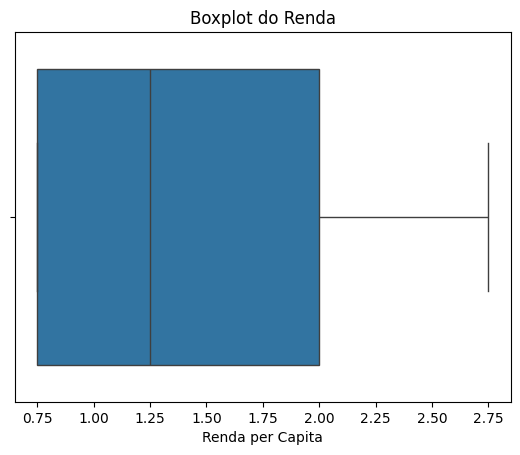

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("/content/data.csv",low_memory=False)
df1 = pd.read_csv("/content/processed_data.csv")

sns.boxplot(x=df1['Renda per Capita'])
plt.title('Boxplot do Renda')
plt.show()

## Convertendo valor de renda per capita para numérico
##### Extraindo os valores de `Renda Per Capita`, transformando de categorico para numerico, atraves da media entre o menor e o maior valor.

In [6]:
import re
import numpy as np

def convert_renda_per_capita(value):
    if isinstance(value, str):
        match = re.match(r"(\d+,\d+|\d+) Sm < Rfp <= (\d+,\d+|\d+) Sm", value)
        if match:
            lower_bound = float(match.group(1).replace(",", "."))
            upper_bound = float(match.group(2).replace(",", "."))
            return (lower_bound + upper_bound) / 2
    return np.nan

df["Renda per Capita"] = df["Renda per Capita"].apply(convert_renda_per_capita)

## Pré-processando valores nulos
##### Processando valores nulos, para valores categoricos atribuir categoria `Desconhecido`, para variaveis numericas, tirando `Renda Per Capita`, atribuimos a media dos valores daquela coluna. Para fins de desenvolvimento, salvamos os dados processados na pasta `./data/processed_data.csv`


In [8]:
def pre_process(df):
    for coluna in df.columns:
        if df[coluna].dtype in ["float64", "int64"]:
            if coluna != "Renda per Capita":
                df[coluna] = df[coluna].fillna(df[coluna].mean())
        elif df[coluna].dtype == "object":
            df[coluna] = df[coluna].fillna("Desconhecido")

    return df

df = pre_process(df)

output_path = '/content/processed_data.csv'
df.to_csv(output_path, index=False)
print(f"Dados processados salvos em: {output_path}")

Dados processados salvos em: /content/processed_data.csv


## Tratando outliers
##### Através do modelo `isolation-florest`, conseguimos extrair os padrões dos dados do nosso dataset, e através desse padrao conseguimos dizer se um certo valor está dentro do padrão ou não, atribuindo um score que é analisado pelo modelo, e de acordo com a contaminação estabelecida e o padrão dos demais scores, deleta ou mantem o valor em questão. Para fins de desenvolvimento, salvamos os dados tratados na pasta `./data/cleaned_data.csv`

In [ ]:
from sklearn.ensemble import IsolationForest

def remove_outliers(df):
    isolation_forest = IsolationForest(contamination=0.05)

    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df_numeric = df[numeric_columns]

    outliers = isolation_forest.fit_predict(df_numeric)

    df_cleaned = df[outliers == 1]

    return df_cleaned

df = remove_outliers(df)
df.to_csv('./data/cleaned_data.csv',index=False)

## Transformando os dados
##### Nessa etapa, fazemos uma mistura de técnicas de transformação de dados, como `one-hot-encoding` e `tfidf` para transformar as variaveis categoricas em variaveis numéricas.

## Treinamento com modelos de regressão
##### Essa etapa consiste em fazer o split do nosso dataset, em dados de treino e de teste, e realizar o treinamento dos nossos dados com o modelo de `linear-regression` e `decision-tree-regression`

## Aplicando testes
##### Nessa etapa, iremos aplicar os testes, e ver como os nossos dados se comportaram diante os dois modelos utilizados, e analisar caracteristicas como viés e variância dos nossos dados, bem como o resultado dos nossos modelos de regressão